In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Data from:https://www.kaggle.com/datasets/laotse/credit-risk-dataset/data

In [ ]:
!kaggle datasets download -d laotse/credit-risk-dataset

  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 72.0MB/s]


In [ ]:
!unzip /content/credit-risk-dataset.zip

Archive:  /content/credit-risk-dataset.zip
replace credit_risk_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
from IPython.display import display
from sklearn.metrics import mutual_info_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import xgboost as xgb
from hyperopt import fmin, tpe, hp,STATUS_OK
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import pickle

In [3]:
df=pd.read_csv('/content/credit_risk_dataset.csv')
print(df.shape)
df.head()

(32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# EDA

- Find missing value and missing type analysis

In [ ]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

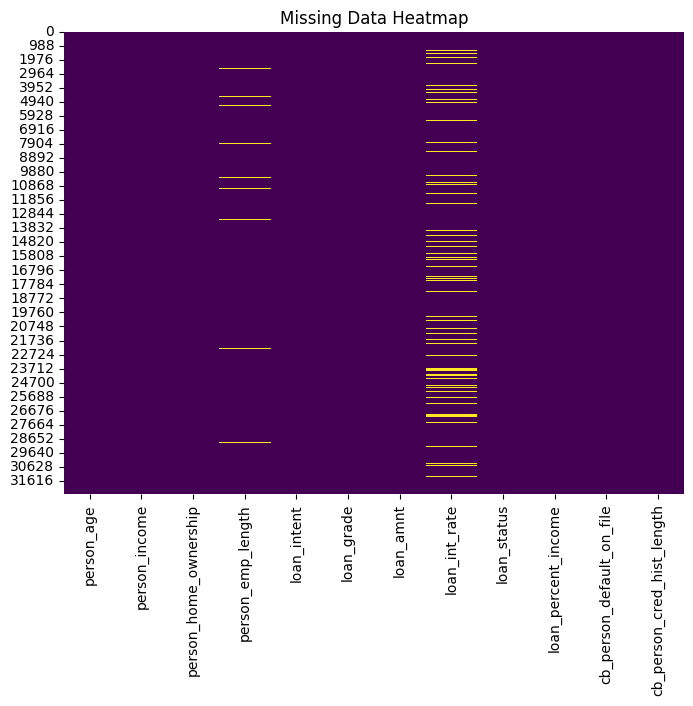

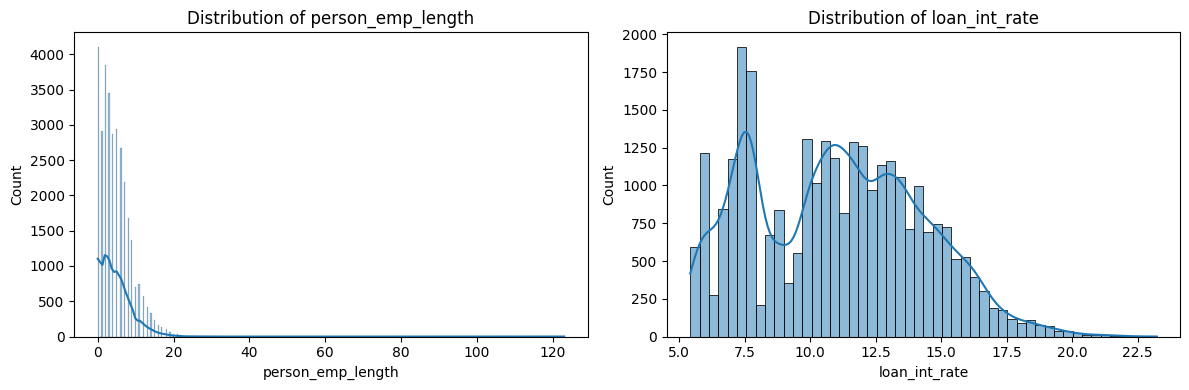

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['person_emp_length'].dropna(), kde=True)
plt.title('Distribution of person_emp_length')

plt.subplot(1, 2, 2)
sns.histplot(df['loan_int_rate'].dropna(), kde=True)
plt.title('Distribution of loan_int_rate')
plt.tight_layout()
plt.show()

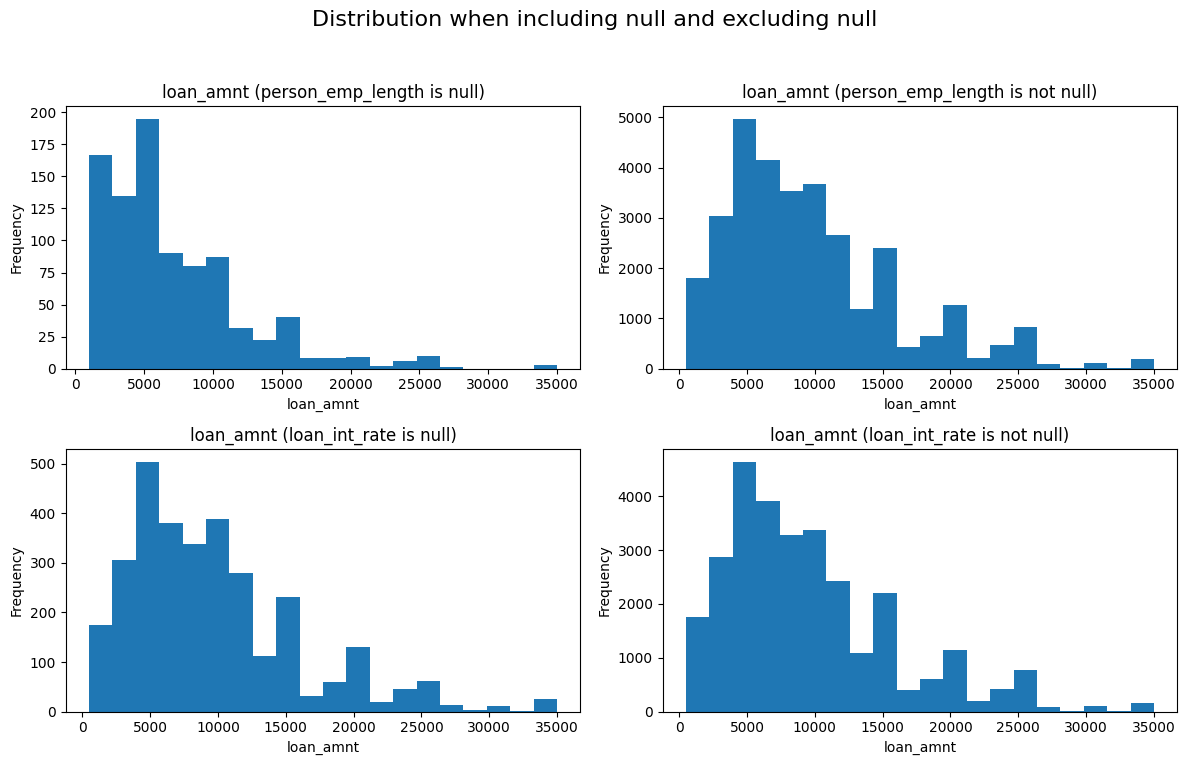

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Distribution when including null and excluding null', fontsize=16)

df[df['person_emp_length'].isnull()]['loan_amnt'].plot(kind='hist', bins=20, ax=axes[0, 0])
axes[0, 0].set_title('loan_amnt (person_emp_length is null)')
axes[0, 0].set_xlabel('loan_amnt')
axes[0, 0].set_ylabel('Frequency')

df[df['person_emp_length'].notnull()]['loan_amnt'].plot(kind='hist', bins=20, ax=axes[0, 1])
axes[0, 1].set_title('loan_amnt (person_emp_length is not null)')
axes[0, 1].set_xlabel('loan_amnt')
axes[0, 1].set_ylabel('Frequency')

df[df['loan_int_rate'].isnull()]['loan_amnt'].plot(kind='hist', bins=20, ax=axes[1, 0])
axes[1, 0].set_title('loan_amnt (loan_int_rate is null)')
axes[1, 0].set_xlabel('loan_amnt')
axes[1, 0].set_ylabel('Frequency')

df[df['loan_int_rate'].notnull()]['loan_amnt'].plot(kind='hist', bins=20, ax=axes[1, 1])
axes[1, 1].set_title('loan_amnt (loan_int_rate is not null)')
axes[1, 1].set_xlabel('loan_amnt')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
column_with_missing = 'loan_int_rate'
non_missing_group = df[df[column_with_missing].notnull()]
missing_group = df[df[column_with_missing].isnull()]

statistic, p_value = mannwhitneyu(non_missing_group['loan_amnt'], missing_group['loan_amnt'])

print(f"Mann-Whitney U Test for {column_with_missing}:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U Test for loan_int_rate:
Statistic: 45742270.5
P-value: 0.7420695103841097


In [ ]:
column_with_missing = 'person_emp_length'
non_missing_group = df[df[column_with_missing].notnull()]
missing_group = df[df[column_with_missing].isnull()]

statistic, p_value = mannwhitneyu(non_missing_group['loan_amnt'], missing_group['loan_amnt'])

print(f"Mann-Whitney U Test for {column_with_missing}:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U Test for person_emp_length:
Statistic: 17985941.0
P-value: 6.913053866531978e-43


In [ ]:
column_with_missing = 'person_emp_length'
non_missing_group = df[df[column_with_missing].notnull()]
missing_group = df[df[column_with_missing].isnull()]

statistic, p_value = mannwhitneyu(non_missing_group['person_income'], missing_group['person_income'])

print(f"Mann-Whitney U Test for {column_with_missing}:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U Test for person_emp_length:
Statistic: 20024995.5
P-value: 1.589534647425549e-98


From the visualize analysis and hypothesis testing implied that
  - loan_int_rate is MCAR(Missing completely at random)
  - person_emp_length - might be MAR (Missing At Random) or MNAR (Missing Not At Random)

11.011694892245036 10.99


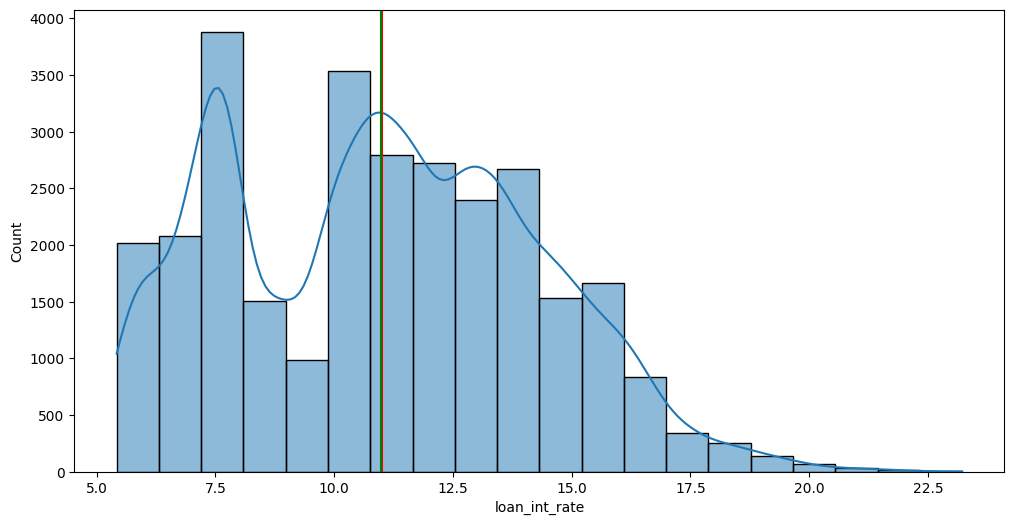

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['loan_int_rate'].dropna(), bins=20, kde=True)

mean, median = df['loan_int_rate'].mean(), df['loan_int_rate'].median()

plt.axvline(mean, color='red')
plt.axvline(median, color ='green')

print(mean, median)

4.789686296787225 4.0


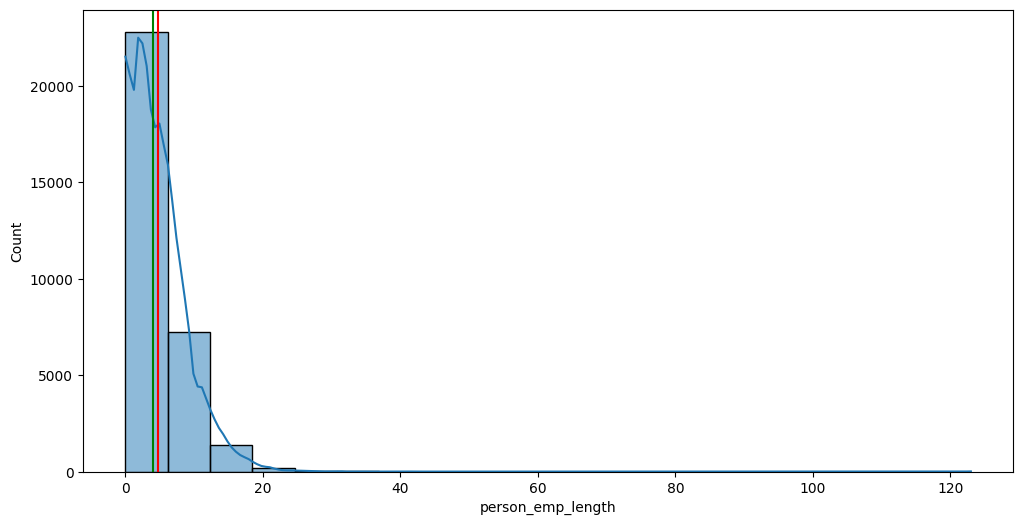

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['person_emp_length'].dropna(), bins=20, kde=True)

mean, median = df['person_emp_length'].mean(), df['person_emp_length'].median()

plt.axvline(mean, color='red')
plt.axvline(median, color ='green')

print(mean, median)

- Inspect type of each columns and value of each catergorical columns

In [ ]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [ ]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [ ]:
df.describe(include='O')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,32581,32581,32581,32581
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,16446,6453,10777,26836


In [ ]:
numerical=df.select_dtypes(include=['number']).columns.tolist()
categorical= df.select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:
for col in categorical:
    print("-"*50)
    print(col)
    print("-"*50)
    print(df.select_dtypes("object")[col].value_counts())

--------------------------------------------------
person_home_ownership
--------------------------------------------------
RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: person_home_ownership, dtype: int64
--------------------------------------------------
loan_intent
--------------------------------------------------
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: loan_intent, dtype: int64
--------------------------------------------------
loan_grade
--------------------------------------------------
A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: loan_grade, dtype: int64
--------------------------------------------------
cb_person_default_on_file
--------------------------------------------------
N    26836
Y     5745
Name: cb_person_default_on_file, dtype: int64


- This bar chart implies to imbalanced data

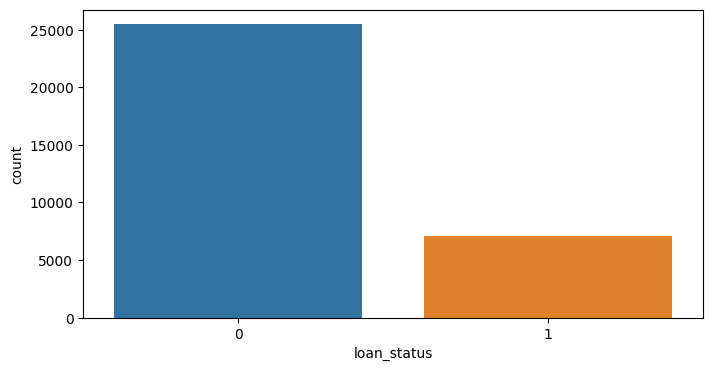

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='loan_status', data=df)
plt.show()

In [ ]:
print("loan_status:0 count:", df['loan_status'].value_counts()[0])
print("loan_status:1 count:", df['loan_status'].value_counts()[1])

loan_status:0 count: 25473
loan_status:1 count: 7108


- Plot Correlation heatmap

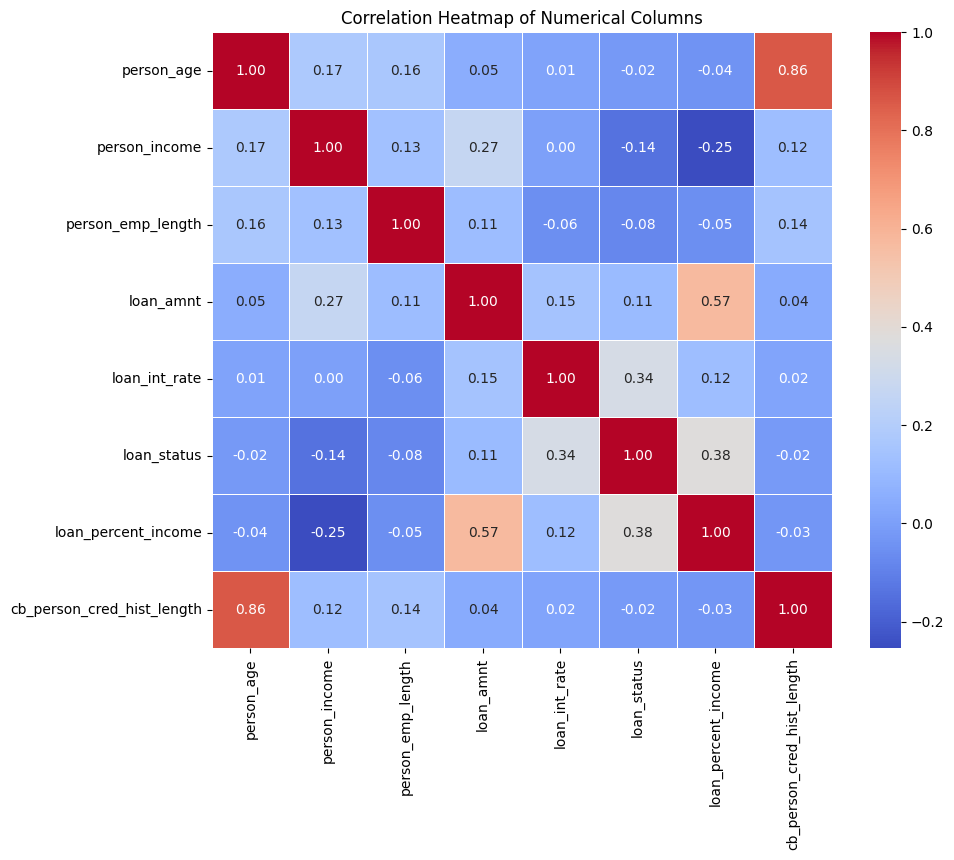

In [ ]:
correlation_matrix = df[numerical].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Columns")
plt.show()

- Pair Plot

<Figure size 1200x800 with 0 Axes>

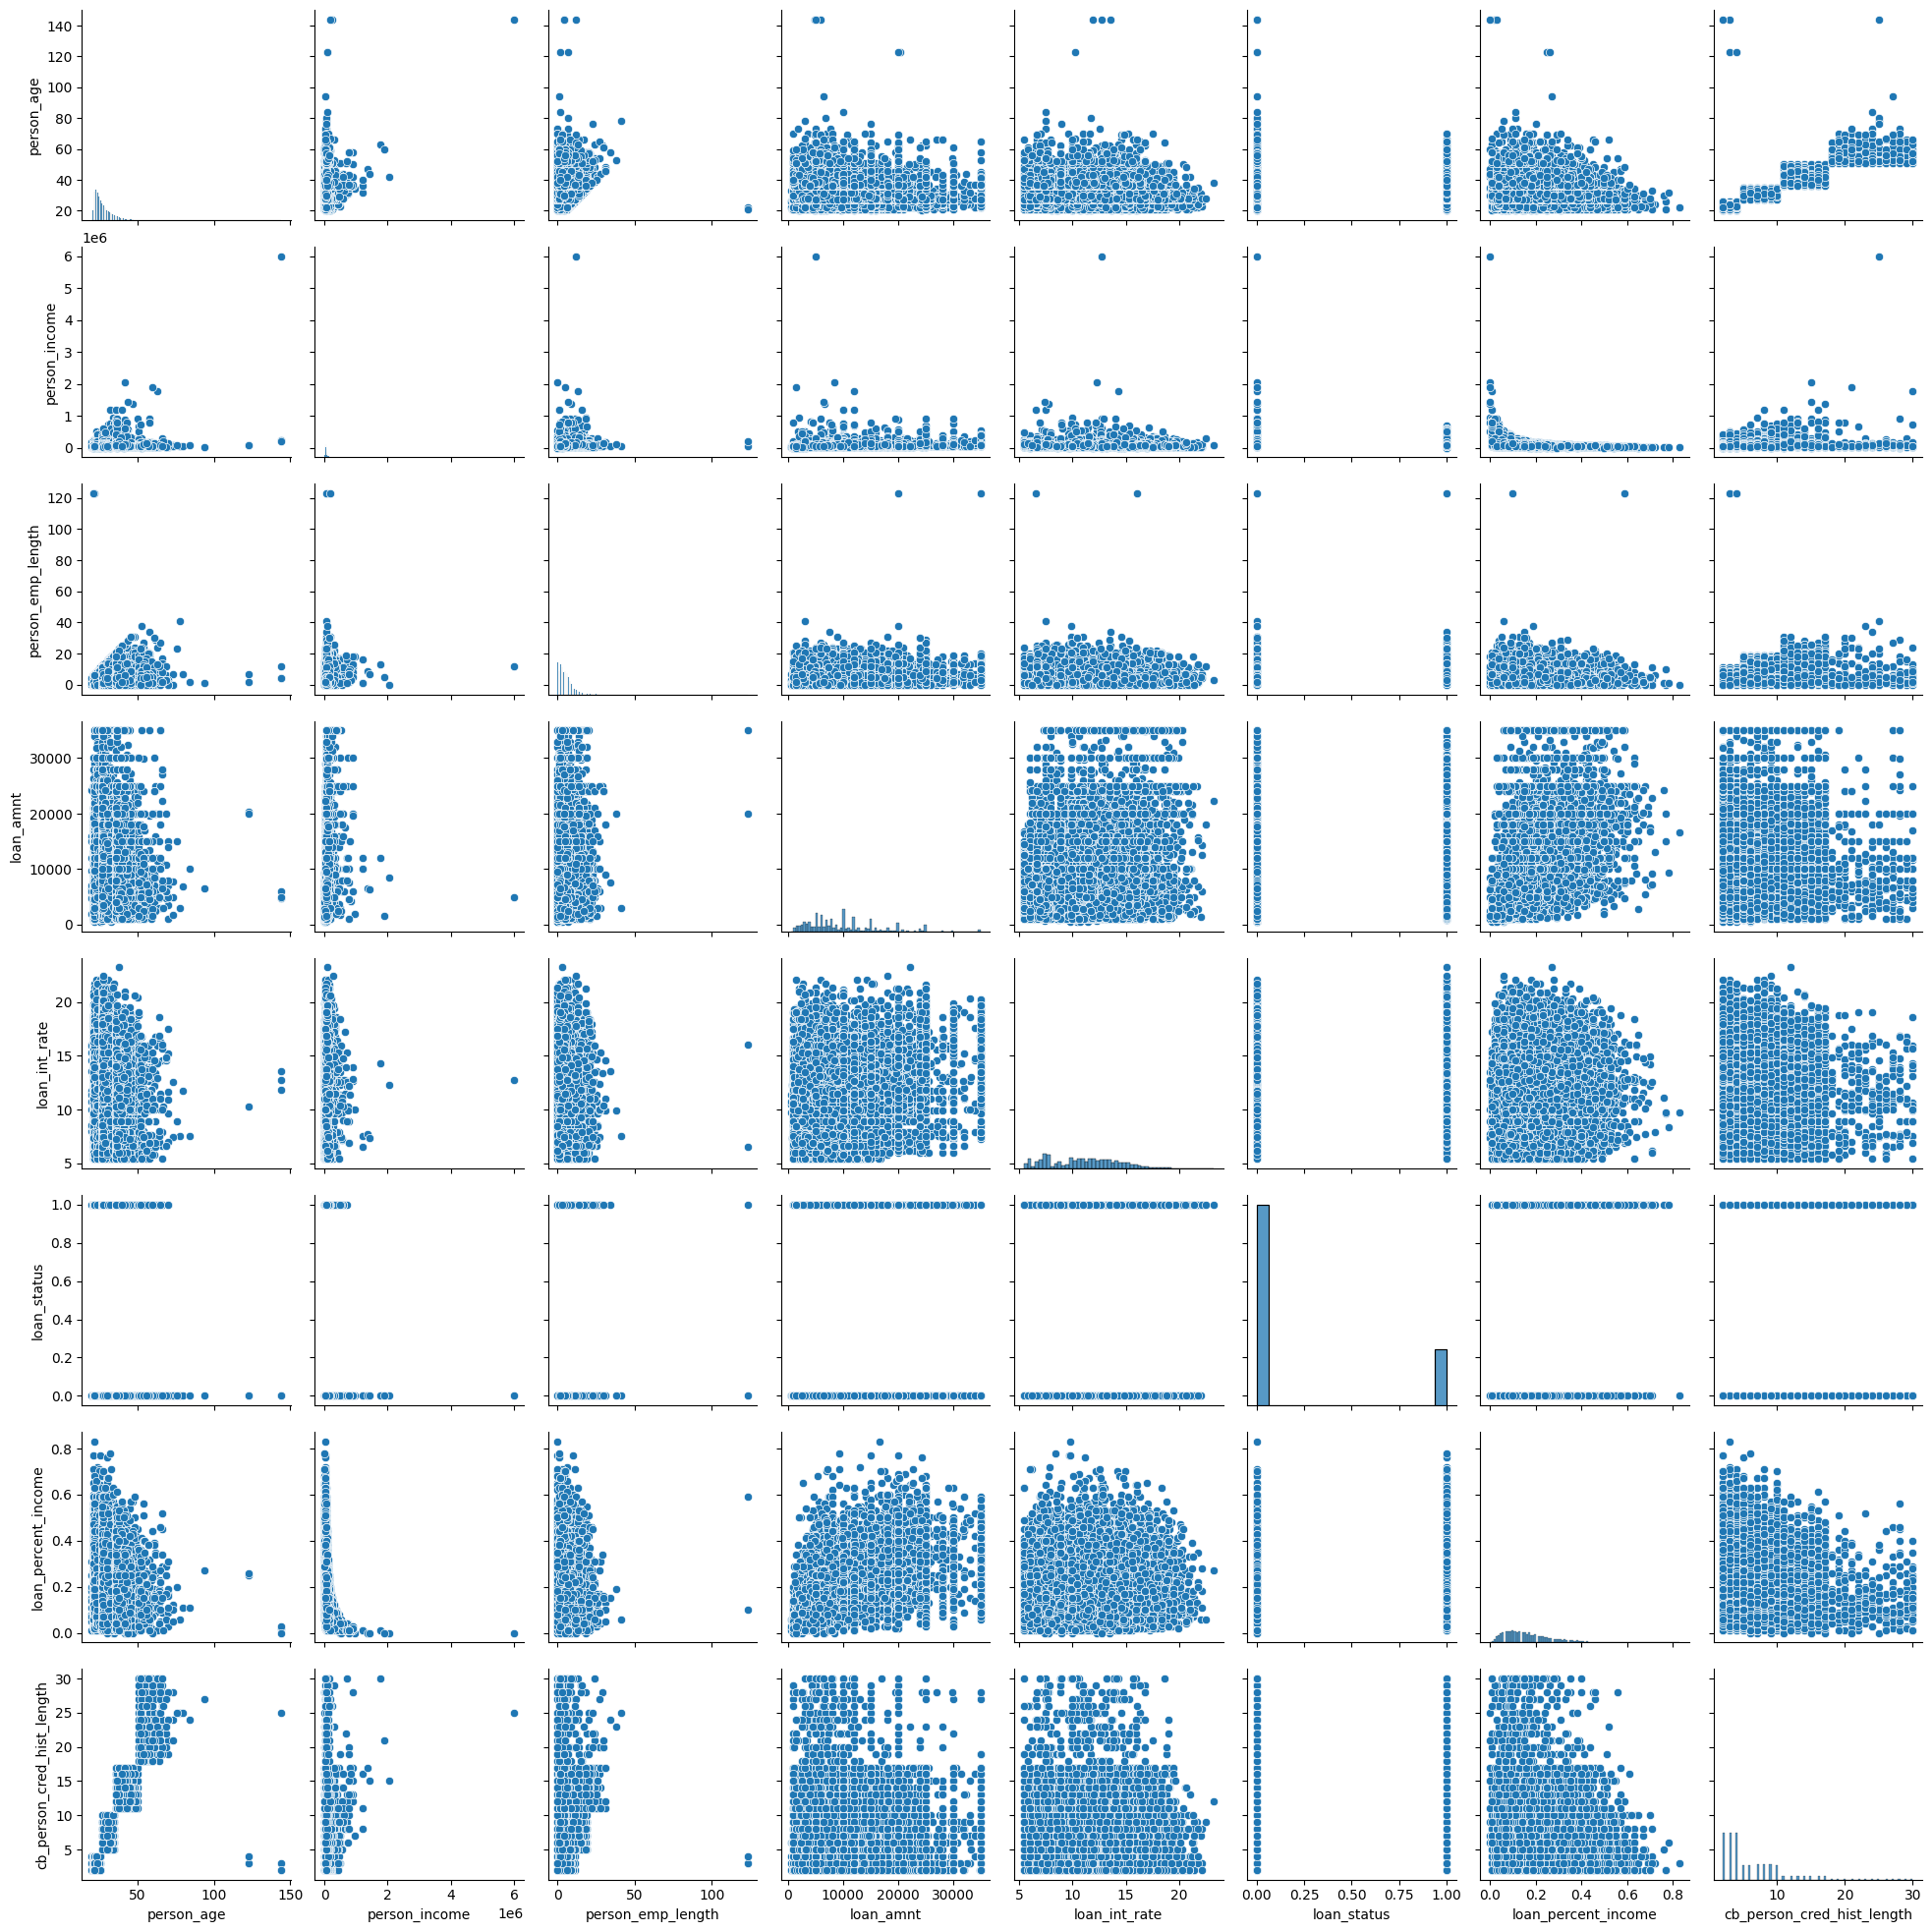

In [ ]:
plt.figure(figsize=(12, 8))
sns.pairplot(df)
plt.show()

- Use mean to define risk analysis on each value in catergorical columns

In [ ]:
global_mean = df.loan_status.mean()
global_mean

0.21816396059052823

In [ ]:
for col in categorical:
    df_group = df.groupby(by=col).loan_status.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,risk
person_home_ownership,,,
MORTGAGE,0.125707,-0.092457,0.576203
OTHER,0.308411,0.090247,1.413667
OWN,0.074690,-0.143474,0.342359
RENT,0.315700,0.097536,1.447076


,mean,diff,risk
loan_intent,,,
DEBTCONSOLIDATION,0.285879,0.067715,1.310385
EDUCATION,0.172168,-0.045996,0.789168
HOMEIMPROVEMENT,0.261026,0.042862,1.196469
MEDICAL,0.267007,0.048843,1.223883
PERSONAL,0.198877,-0.019287,0.911594
VENTURE,0.148103,-0.070061,0.678860


,mean,diff,risk
loan_grade,,,
A,0.099564,-0.118600,0.456372
B,0.162760,-0.055404,0.746042
C,0.207340,-0.010824,0.950385
D,0.590458,0.372294,2.706486
E,0.644191,0.426027,2.952783
F,0.705394,0.487230,3.233321
G,0.984375,0.766211,4.512088


,mean,diff,risk
cb_person_default_on_file,,,
N,0.183932,-0.034232,0.843091
Y,0.378068,0.159904,1.732953


- Mutual Information

In [ ]:
def calculate_mi(series):
    return mutual_info_score(series, df.loan_status)

In [ ]:
mi=df[categorical].apply(calculate_mi)
mi.sort_values(ascending=False)

loan_grade                   0.074487
person_home_ownership        0.030677
cb_person_default_on_file    0.014507
loan_intent                  0.008076
dtype: float64

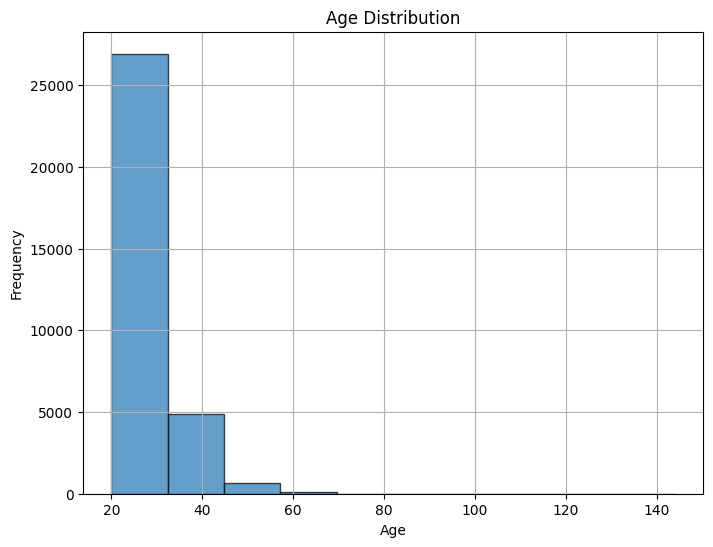

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['person_age'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
df[df['person_age']>80]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N,3
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0,0.26,N,4
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N,25
32416,94,24000,RENT,1.0,MEDICAL,C,6500,NaN,0,0.27,N,27
32506,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,7.51,0,0.11,N,24


- Drop these error age value

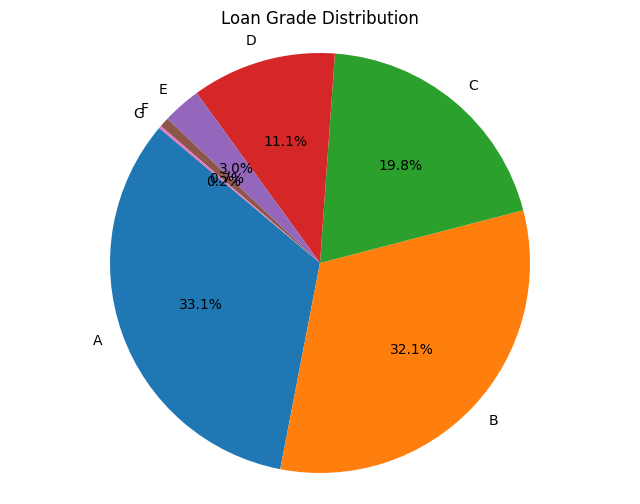

In [ ]:
plt.figure(figsize=(8, 6))
plt.pie(df['loan_grade'].value_counts(), labels=df['loan_grade'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Loan Grade Distribution')
plt.axis('equal')

plt.show()

- Loan grade

# Feature engineering

In [4]:
# Drop unreal case
df = df.drop(df[df['person_age'] > 80].index, axis=0)
df = df.drop(df[df['person_emp_length'] > 65].index, axis=0)

In [ ]:
def get_ratio_loan_income(df):
    df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']
    return df

In [ ]:
def get_ratio_int_loan(df):
    df['int_rate_to_loan_amt_ratio'] = df['loan_int_rate'] / df['loan_amnt']
    return df

In [ ]:
def binning_age(df):
    df['age_group'] = pd.cut(df['person_age'],
                           bins=[20, 30, 40, 50, 60, 70],
                           labels= ['20-29', '30-39', '40-49', '50-59', '60-69'])
    return df

In [ ]:
def binning_income(df):
    df['income_group'] = pd.cut(df['person_income'],
                              bins=[0, 25000, 50000, 75000, 100000, float('inf')],
                              labels=['low', 'low-middle', 'middle', 'high-middle', 'high'])

    return df

In [ ]:
def binning_loan(df):
    df['loan_amount_group'] = pd.cut(df['loan_amnt'],
                                   bins=[0, 5000, 10000, 15000, float('inf')],
                                   labels=['small', 'medium', 'large', 'very large'])


    return df

In [5]:
numerical=df.select_dtypes(include=['number']).columns.tolist()
categorical= df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical.remove('loan_status')

In [ ]:
fea_eng = ColumnTransformer([
    ('loan_to_income_ratio', FunctionTransformer(get_ratio_loan_income, validate=False),
     ['loan_amnt', 'person_income']),
    ('int_rate_to_loan_amt_ratio', FunctionTransformer(get_ratio_int_loan, validate=False),
     ['loan_int_rate', 'loan_amnt']),
    ('age_group', FunctionTransformer(binning_age, validate=False),
     ['person_age']),
    ('income_group', FunctionTransformer(binning_income, validate=False),
     ['person_income']),
    ('loan_amount_group', FunctionTransformer(binning_loan, validate=False),
     ['loan_amnt'])
],remainder="passthrough")

In [6]:
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
    ])

In [7]:
cat_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ])

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        #('feature_engineering', fea_eng, numerical),
        ('numeric_transformers', numeric_transformer, numerical),
        ('categorical_transformers', cat_transformer, categorical),
    ])

# Preprocessing

- Split and use SMOTE to fix imbalance data

In [32]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
X_train=preprocessor.fit_transform(X_train)

In [34]:
sm = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [35]:
y_train.value_counts()

0    20376
1    20376
Name: loan_status, dtype: int64

# Model Creation

- Logistic Regression with grid search

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}
lr = LogisticRegression(solver='liblinear', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='f1', cv=cv)
grid_search.fit(X_train, y_train)

best_lr = grid_search.best_estimator_

In [ ]:
X_test=preprocessor.transform(X_test)
y_pred_test = best_lr.predict(X_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"F1-score on Test Data: {f1_test}")

F1-score on Test Data: 0.6398145465082584


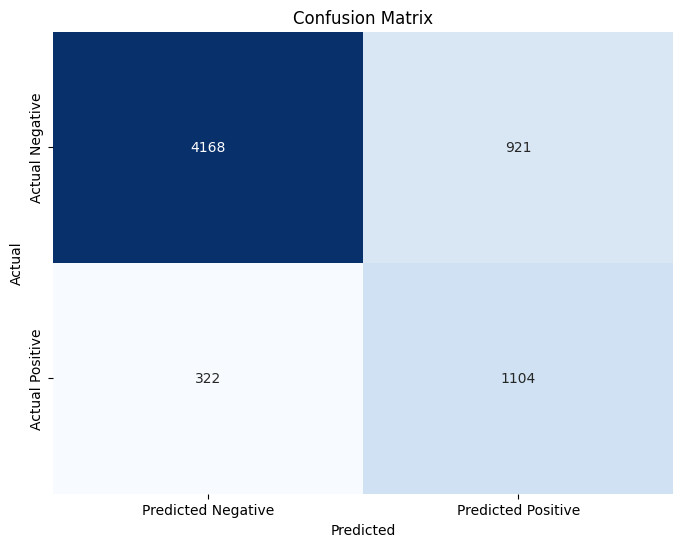

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
target_names = ['non-default', 'default']
print(classification_report(y_test, y_pred_test,target_names=target_names))

              precision    recall  f1-score   support

 non-default       0.93      0.82      0.87      5089
     default       0.55      0.77      0.64      1426

    accuracy                           0.81      6515
   macro avg       0.74      0.80      0.76      6515
weighted avg       0.84      0.81      0.82      6515



- XGBoost with Baysian search

In [ ]:
space = {
    'max_depth': hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

def objective(params):
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    score = f1_score(y_test, y_pred)
    return {'loss': -score,'status': STATUS_OK}

In [ ]:
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

100%|██████████| 100/100 [18:29<00:00, 11.10s/trial, best loss: -0.7909943714821763]
Best set of hyperparameters:  {'learning_rate': 0.009867297631087988, 'max_depth': 7, 'subsample': 0.7149922176546912}


In [36]:
best_xgb = xgb.XGBClassifier(
    max_depth=7,
    learning_rate=0.01,
    subsample=0.7,
)

best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [37]:
X_test=preprocessor.transform(X_test)
y_pred_test = best_xgb.predict(X_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"F1-score on Test Data: {f1_test}")

F1-score on Test Data: 0.8092259577795152


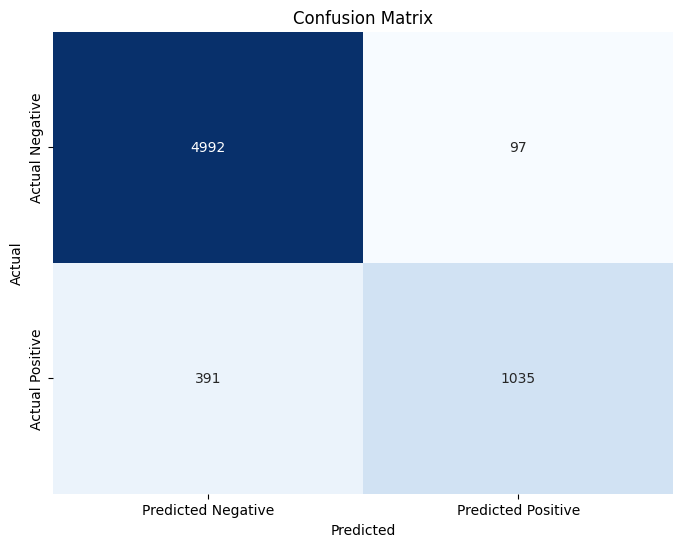

In [38]:
conf_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
target_names = ['non-default', 'default']
print(classification_report(y_test, y_pred_test,target_names=target_names))

              precision    recall  f1-score   support

 non-default       0.93      0.96      0.94      5089
     default       0.84      0.73      0.78      1426

    accuracy                           0.91      6515
   macro avg       0.88      0.85      0.86      6515
weighted avg       0.91      0.91      0.91      6515



- Choose XGBoost to create feature importance

In [ ]:
tmp=df.copy()
tmp_dict = tmp[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(tmp_dict)
dv.transform(tmp_dict)

array([[3.0e+00, 0.0e+00, 1.0e+00, ..., 0.0e+00, 1.0e+00, 5.9e+04],
       [2.0e+00, 1.0e+00, 0.0e+00, ..., 1.0e+00, 0.0e+00, 9.6e+03],
       [3.0e+00, 1.0e+00, 0.0e+00, ..., 0.0e+00, 0.0e+00, 9.6e+03],
       ...,
       [2.8e+01, 1.0e+00, 0.0e+00, ..., 0.0e+00, 1.0e+00, 7.6e+04],
       [2.6e+01, 1.0e+00, 0.0e+00, ..., 0.0e+00, 0.0e+00, 1.5e+05],
       [3.0e+01, 1.0e+00, 0.0e+00, ..., 0.0e+00, 1.0e+00, 4.2e+04]])

In [ ]:
feature_name=dv.get_feature_names_out()

In [ ]:
feature_name

array(['cb_person_cred_hist_length', 'cb_person_default_on_file=N',
       'cb_person_default_on_file=Y', 'loan_amnt', 'loan_grade=A',
       'loan_grade=B', 'loan_grade=C', 'loan_grade=D', 'loan_grade=E',
       'loan_grade=F', 'loan_grade=G', 'loan_int_rate',
       'loan_intent=DEBTCONSOLIDATION', 'loan_intent=EDUCATION',
       'loan_intent=HOMEIMPROVEMENT', 'loan_intent=MEDICAL',
       'loan_intent=PERSONAL', 'loan_intent=VENTURE',
       'loan_percent_income', 'person_age', 'person_emp_length',
       'person_home_ownership=MORTGAGE', 'person_home_ownership=OTHER',
       'person_home_ownership=OWN', 'person_home_ownership=RENT',
       'person_income'], dtype=object)

In [ ]:
explainer = shap.Explainer(best_xgb,feature_names=feature_name)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap_result = pd.DataFrame(shap_values, columns = feature_name)
vals = np.abs(shap_result.values).mean(0)
feature_names_list = feature_name.tolist()
shap_importance = pd.DataFrame(list(zip(feature_names_list, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance.head()

,col_name,feature_importance_vals
18,loan_percent_income,0.325040
11,loan_int_rate,0.320042
25,person_income,0.206043
24,person_home_ownership=RENT,0.129117
6,loan_grade=C,0.063761


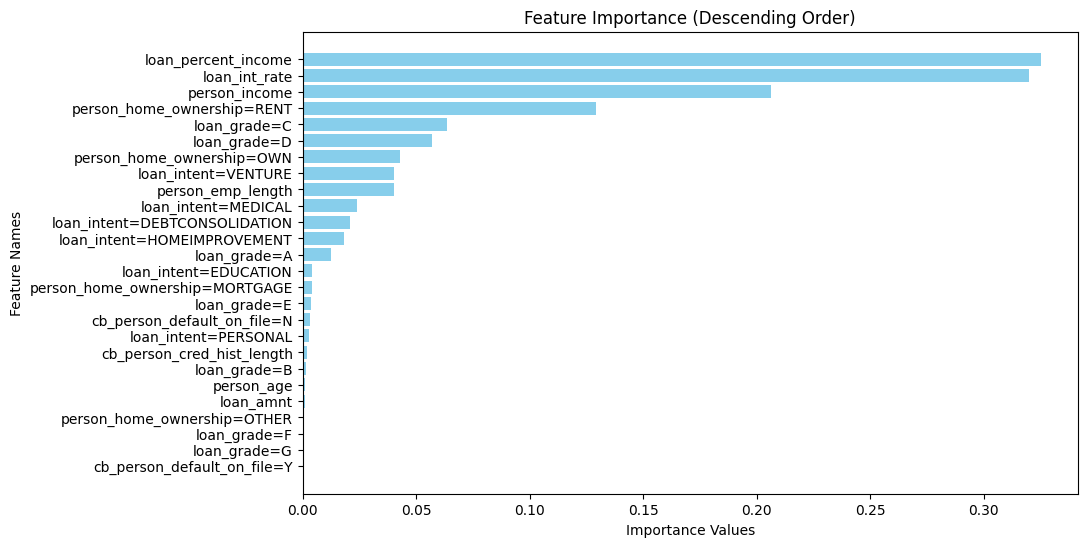

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(shap_importance['col_name'], shap_importance['feature_importance_vals'], color='skyblue')
plt.xlabel('Importance Values')
plt.ylabel('Feature Names')
plt.title('Feature Importance (Descending Order)')
plt.gca().invert_yaxis()
plt.show()

- ANN

In [21]:
def create_ann_model(hidden_units=64, dropout_rate=0.2, l2_regularizer=0.01):
    model = keras.Sequential([
        keras.layers.Dense(hidden_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

In [22]:
model=create_ann_model()

In [24]:
model.fit(X_train, y_train, batch_size = 32, epochs = 25,verbose = 0)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1728      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3841 (15.00 KB)
Trainable params: 3841 (15.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
X_test=preprocessor.transform(X_test)
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

204/204 [==============================] - 2s 6ms/step


In [28]:
f1_test = f1_score(y_test, y_pred)

print(f"F1-score on Test Data: {f1_test}")

F1-score on Test Data: 0.7675485008818342


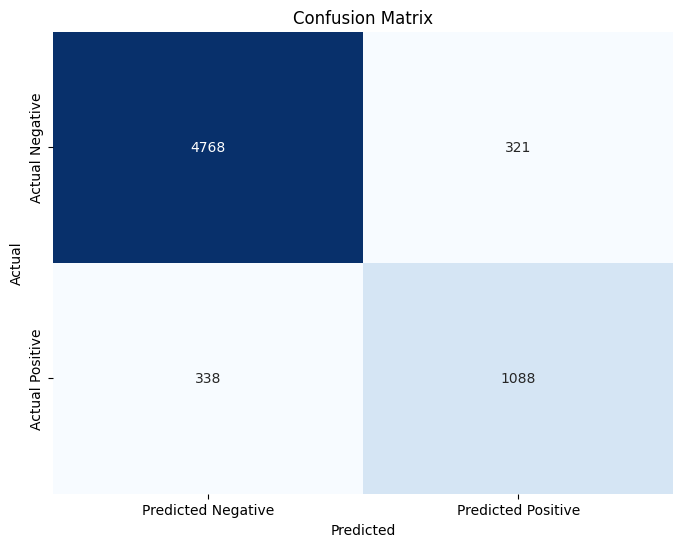

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [30]:
target_names = ['non-default', 'default']
print(classification_report(y_test, y_pred,target_names=target_names))

              precision    recall  f1-score   support

 non-default       0.93      0.94      0.94      5089
     default       0.77      0.76      0.77      1426

    accuracy                           0.90      6515
   macro avg       0.85      0.85      0.85      6515
weighted avg       0.90      0.90      0.90      6515



# Save best model

In [39]:
with open('model.bin', 'wb') as f_out:
   pickle.dump((preprocessor, best_xgb), f_out)
f_out.close()

# Load and test model

In [40]:
with open('model.bin', 'rb') as f_in:
    preprocessor, best_xgb = pickle.load(f_in)
f_in.close()

In [41]:
preprocessor, best_xgb

(ColumnTransformer(transformers=[('numeric_transformers',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', StandardScaler())]),
                                  ['person_age', 'person_income',
                                   'person_emp_length', 'loan_amnt',
                                   'loan_int_rate', 'loan_percent_income',
                                   'cb_person_cred_hist_length']),
                                 ('categorical_transformers',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(fill_value='missing',
                                                                 strategy='constant')),
                                                  ('onehot',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['person_home_o

In [ ]:
df.iloc[5].to_dict()

{'person_age': 21,
 'person_income': 9900,
 'person_home_ownership': 'OWN',
 'person_emp_length': 2.0,
 'loan_intent': 'VENTURE',
 'loan_grade': 'A',
 'loan_amnt': 2500,
 'loan_int_rate': 7.14,
 'loan_status': 1,
 'loan_percent_income': 0.25,
 'cb_person_default_on_file': 'N',
 'cb_person_cred_hist_length': 2}

In [42]:
customer={'person_age': 21,
 'person_income': 9900,
 'person_home_ownership': 'OWN',
 'person_emp_length': 2.0,
 'loan_intent': 'VENTURE',
 'loan_grade': 'A',
 'loan_amnt': 2500,
 'loan_int_rate': 7.14,
 'loan_percent_income': 0.25,
 'cb_person_default_on_file': 'N',
 'cb_person_cred_hist_length': 2}

In [44]:
customer_df = pd.DataFrame([customer])

In [46]:
transformed_customer=preprocessor.transform(customer_df)

In [47]:
y=model.predict(transformed_customer)

1/1 [==============================] - 0s 32ms/step


In [48]:
y

array([[0.99744004]], dtype=float32)